# Part ?? - **Interpretació**

Quan treballem amb models de machine learning, ens interessa obtenir una explicació sobre perquè un model ha generat una predicció. Això és el que intentarem definir en aquest notebook, amb els mètodes **CAM i GradCAM**. Els dos mètodes ens permetes obtenir un heatmap que ens identifica quines regions són relativament importants per la xarxa alhora de realitzar la tasca de classificació.

### **1. Carregar Imatges**

En aquest cas, carregarem el model ``resnet152`` que ja teníem entrenat i guardat.

In [82]:
### PYCHARM ###

import fastai
import torch
from fastai.vision.all import *
from fastai.callback.fp16 import *
from IPython.display import Image

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch


path = "dataset_CIFAR10"

In [2]:
### COLAB ###
"""
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
from fastbook import *
fastbook.setup_book()
from fastai.callback.fp16 import *

!unzip /content/gdrive/MyDrive/dataset_CIFAR10.zip
path = "/content/"
"""

'\n! [ -e /content ] && pip install -Uqq fastbook\nimport fastbook\nfrom fastbook import *\nfastbook.setup_book()\nfrom fastai.callback.fp16 import *\n\n!unzip /content/gdrive/MyDrive/dataset_CIFAR10.zip\npath = "/content/"\n'

In [3]:
#check if cuda is available
torch.cuda.is_available()

True

In [38]:
dls = ImageDataLoaders.from_folder(
    path=path,
    train='train',
    valid='validation',
    seed=42,
    bs = 64,
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

In [39]:
learn152 = load_learner(path+"/resnet152.pkl", cpu=False)

### **2. Class Activation Map (CAM)**

Utilitza l'output de la última capa convolucional juntament amb les prediccions per generar un heatmap, que ens permet saber quines regions d'una imatge han sigut rellevants per una classe en concret (en què es fixa la xarxa per dir que una imatge correspon a una classe en concret). S'han seguit les explicacions d'[aquí](http://ethen8181.github.io/machine-learning/keras/resnet_cam/resnet_cam.html#CAM-(Class-Activation-Map)) i [aquí](https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb).


El seu funcionament es pot visualitzar en el següent diagrama:

<center>

![_Class Activation Map](https://miro.medium.com/v2/resize:fit:720/format:webp/1*O5azF2X0KF1NQmpcooXF1Q.png)

</center>

O bé en l'equació següent:

$M_{c}(x,y) = \sum_{k}w^{c}_{k} \cdot f_{k}(x,y)$

a on:

   * $f_{k}(x,y)$ és l'activació de la última capa convolucional per l'activació $k$ per a localització espacial $x,y$ (localització en amplitud i alçada)
   * $w^{c}$ són els pesos de la capa densa donada una classe $c$ i una unitat d'activació $k$
   * $M_{c}(x,y)$ és el CAM (class activation map) per una classe $c$, que indica la importància de l'activació a la localització espacial $x,y$
   
   
Comencem pas a pas amb el codi:

In [40]:
# Define a hook that stores a copy of the output
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

Després, llegim la imatge que volem analitzar:

In [41]:
# Load an image of a cat
test_items = [str(path)+'/train/cat/0080.jpg'] 
    
# Get a batch of data from the test set
x, = first(dls.test_dl(test_items))

Creem una instància ``Hook`` com a context manager (es registra quan s'hi entra i es treu automàticament quan se surt), agafem el batch (amb la imatge triada) i el passem al nostre model. Després, n'agafem l'activació ``act`` (es correspon a $f_k(x,y)$).

In [48]:
# Perform inference on the test batch
with Hook(learn152.model[0]) as hook:
    with torch.no_grad(): output = learn152.model.eval()(x.cuda())
    act = hook.stored.squeeze()

A continuació, multipliquem els pesos de la capa densa  ``learn152.model[1][-1].weight`` ($w^c_k$) amb l'activació ``act``... **i veiem que no funciona!** 

In [49]:
cam_map = torch.einsum('ck,kij->cij', learn152.model[1][-1].weight, act)

RuntimeError: einsum(): subscript k has size 2048 for operand 1 which does not broadcast with previously seen size 512

Això és perquè en una ``resnet152`` la última capa convolucional i la d'activació no són de la mateixa mida:

In [50]:
learn152.model[1][-1].weight.shape

torch.Size([10, 512])

In [51]:
act.shape

torch.Size([2048, 7, 7])

Si fessim servir una ``resnet34`` sí funcionaria per exemple. Per tant, haurem de buscar una alternativa, la proposada [aquí](https://forums.fast.ai/t/cnn-interpretation-with-cam-wrong-shapes-using-resnet-50/89393). El que farem serà mostar simplement una mitjana de les activacions ``act``. D'aquesta manera, enlloc de dir què fa pensar al model que una imatge pertany a una classe determinada, direm en quines parts de la imatge s'ha fixat el model per fer la predicció que ha fet.

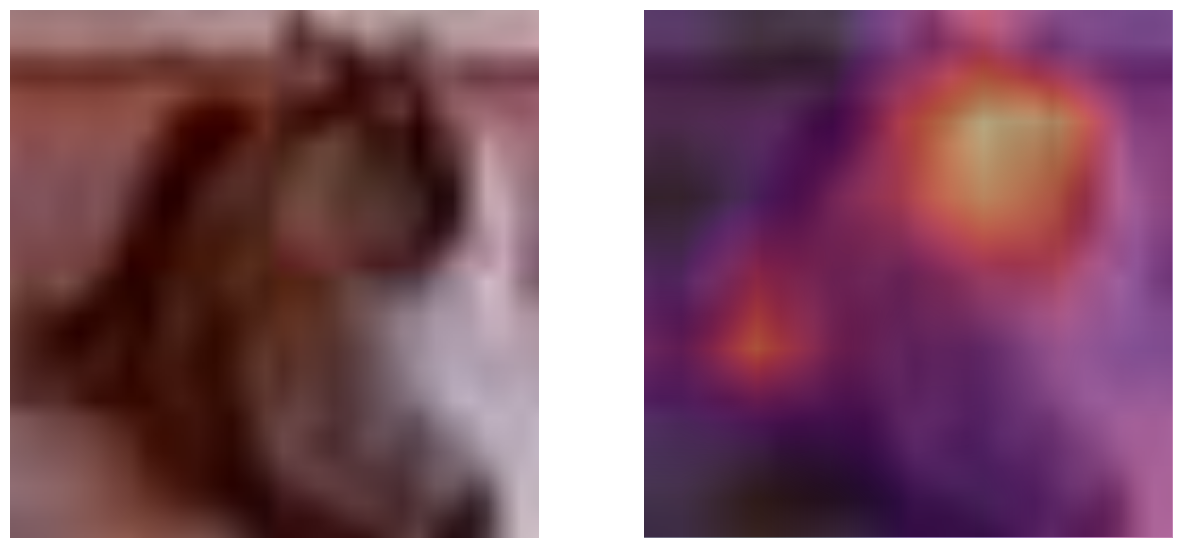

In [52]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])

fig, ax = plt.subplots(1, 2, figsize=(15, 15))

x_dec.show(ctx=ax[0])

x_dec.show(ctx=ax[1])
ax[1].imshow(act.mean(0).detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

Veiem com sembla que es fixa en la part de la cua i el cap.

### **3. Gradient CAM (GradCam)**

El mètode CAM només ens deixa veure un heatmap de les últimes activacions, però això no funciona per capes internes de la xarxa neuronal (només per la última). GradCAM és una generalització del CAM, que utilitza els gradients calculats durant el back propagation donats una classe específica i respecte una capa convolucional concreta. És a dir, les zones on aquest gradient és més elevat són les zones en què la puntuació final del model depèn més.

<center>

![_GradCAM](https://miro.medium.com/v2/resize:fit:720/format:webp/1*zq1lp5Bg8sdflG_ngrezzg.png)

</center>

Començarem registrant la classe ``HookBwd`` per guardar els gradients:

In [17]:
# Define a hook that stores a copy of the gradients calculated by PyTorch during the backward pass
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

Com que hem d'especificar la classe que volem avaluar, mostrem el vocabulari:

In [72]:
dls.vocab

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Ara, donada una classe ``cls`` (com que la imatge que estem provant és un gat, serà  ``3``), una capa  ``layer`` (de moment la última, per tant,  ``-1``) i la imatge  ``x`` amb què ja estàvem treballant, n'obtindrem els gradients:

In [68]:
cls = 3
layer = [-1]
with HookBwd(learn152.model[0][-1]) as hookg:
    with Hook(learn152.model[0][-1]) as hook:
        output = learn152.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

I multipliquem els gradients (com si fossin els pesos) amb les activacions, mostrem la imatge:

In [74]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

I mostrem:

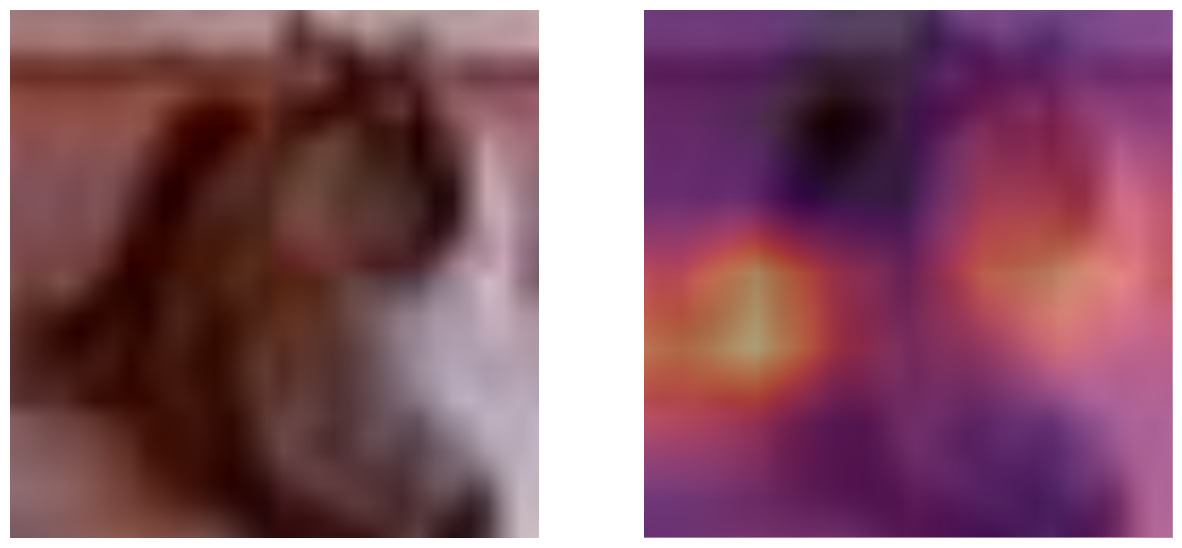

In [75]:
_,ax = plt.subplots(1, 2, figsize=(15, 15))
x_dec.show(ctx=ax[0])
x_dec.show(ctx=ax[1])

ax[1].imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');


Veiem que la última capa sembla se centra en el cap i la cua del gat (com amb el mètode CAM).

Per tal de facilitar la visualització, podem encapsular el codi anterior en una funció que donat una imatge i una capa, et mostra en quines parts es fixa la capa determinada  per dir que aquella imatge pertany a cada classe:

In [78]:
def gradcam(img, layer):


    # Load an image of a cat
    test_items = [img] 
    
    # Get a batch of data from the test set
    x, = first(dls.test_dl(test_items))

    # Get the first image from the test batch
    x_dec = TensorImage(dls.train.decode((x,))[0][0])

    #grid of images with increased size
    fig, ax = plt.subplots(4, 3, figsize=(15, 15))

    for i in range(4):
        for j in range(3):

            #The class index
            cls = i*3+j-1

            if i == 0 and j == 0:
                x_dec.show(ctx=ax[i][j])
                ax[i][j].set_title('Original')

            elif cls < len(dls.vocab):

                with HookBwd(learn152.model[0][layer]) as hookg:
                    with Hook(learn152.model[0][layer]) as hook:
                        output = learn152.model.eval()(x.cuda())
                        act = hook.stored

                    # Get the gradients for the class for the first image in the test set
                    output[0,cls].backward()
                    grad = hookg.stored

                # Calculate the average of the gradients across the feature map
                w = grad[0].mean(dim=[1,2], keepdim=True)
                cam_map = (w * act[0]).sum(0)

                x_dec.show(ctx=ax[i][j])

                
                ax[i][j].imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
                                interpolation='bilinear', cmap='magma');
                ax[i][j].set_title(dls.vocab[cls])

I la provem:

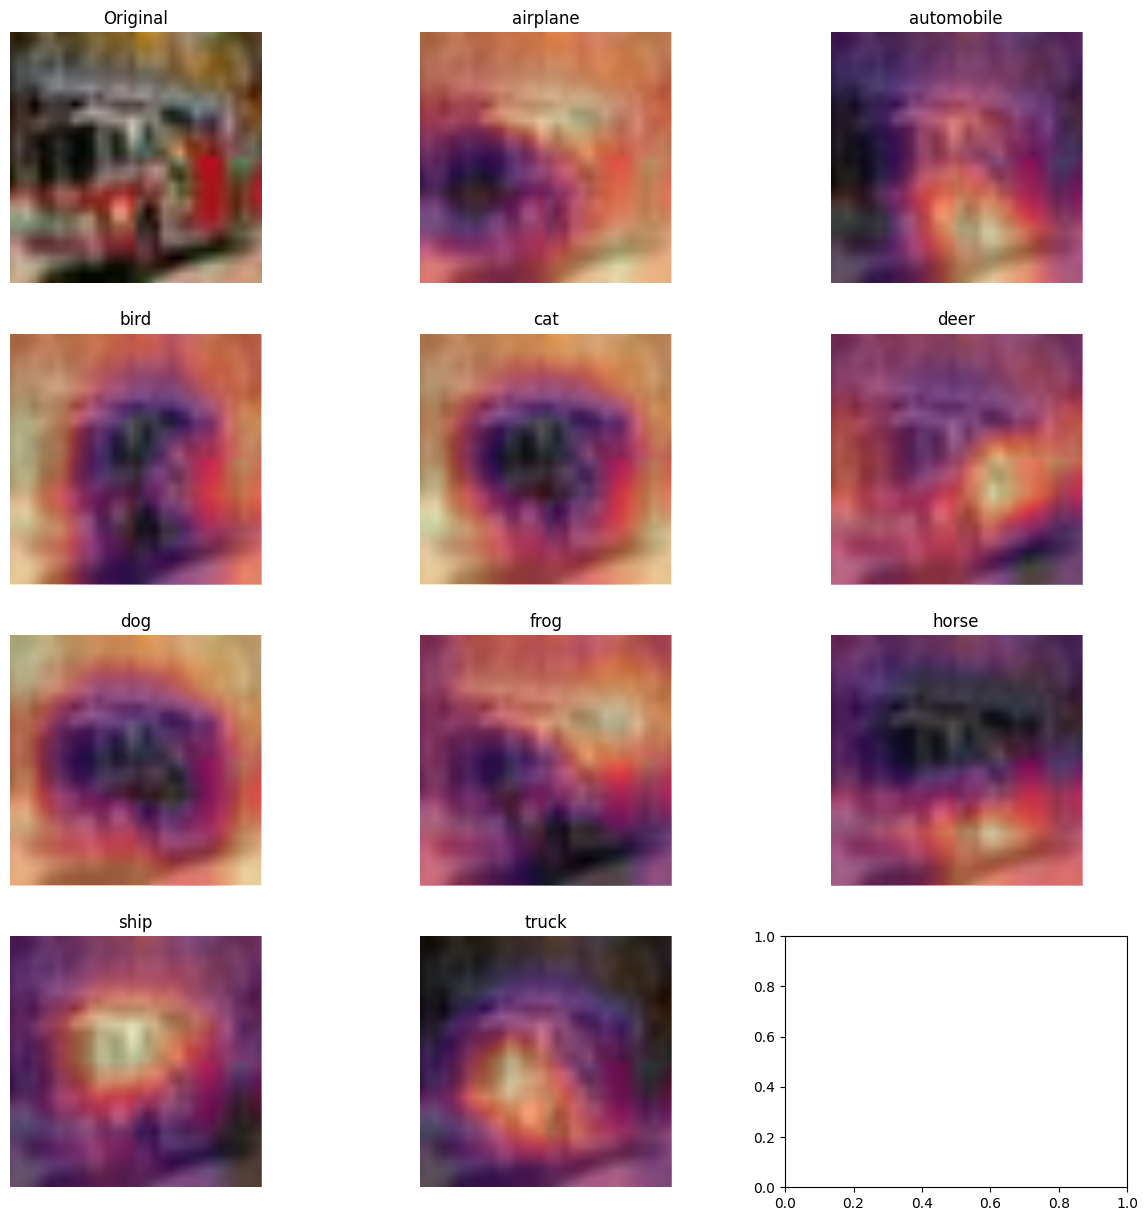

In [80]:
gradcam(str(path)+'/train/truck/0187.jpg', -1)

Veiem que la última capa, per la classe camió es fixa sobretot en la part de davant (cabina i roda).

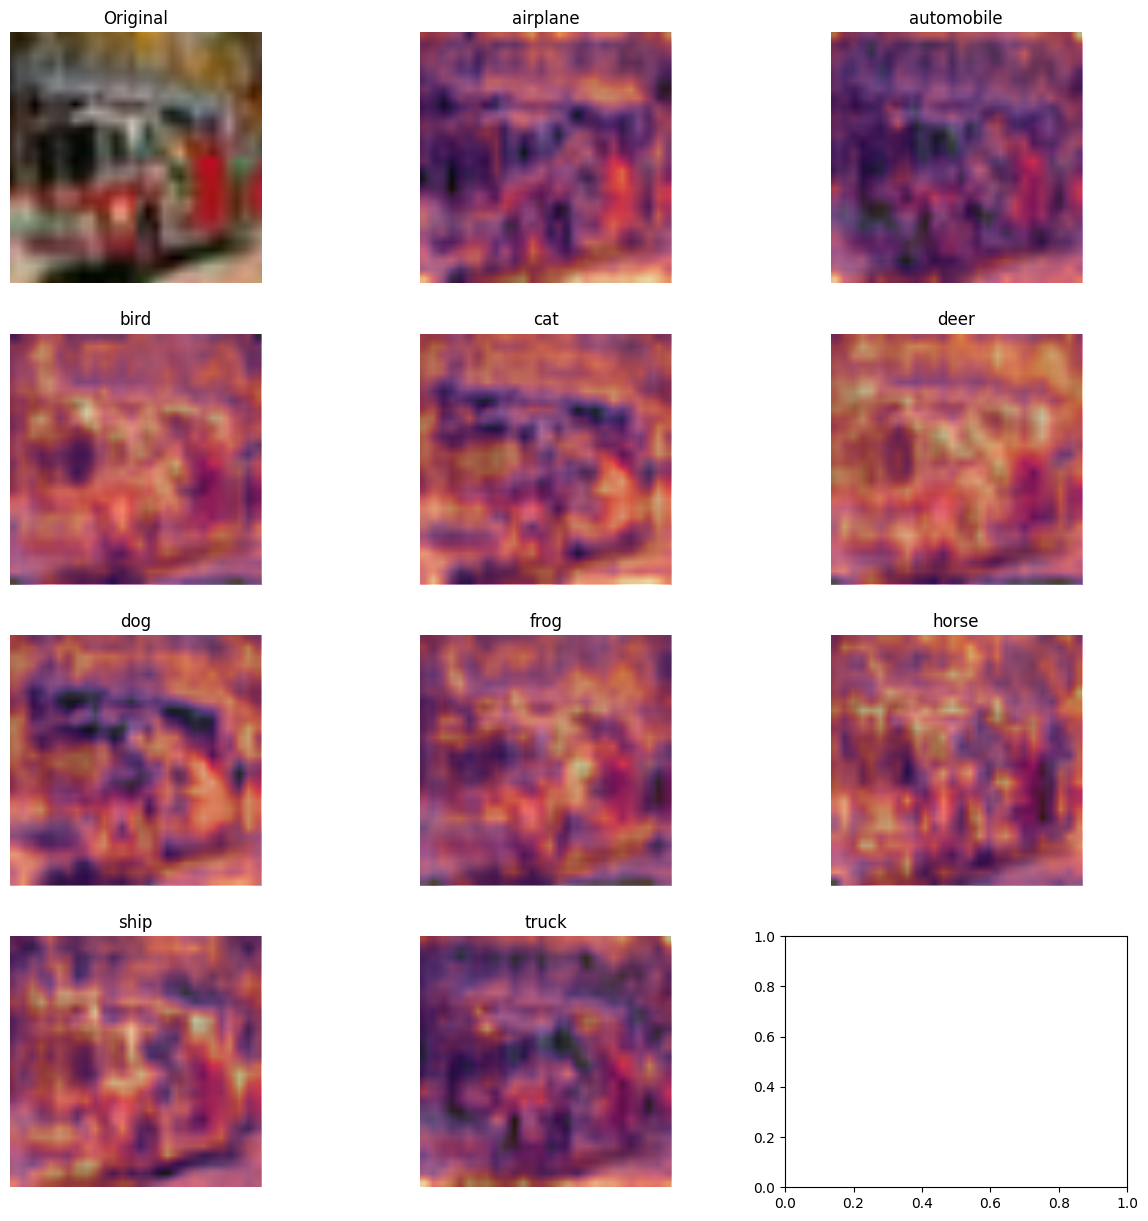

In [81]:
gradcam(str(path)+'/train/truck/0187.jpg', -3)

En canvi, a mesura que analitzem capes que es troben més al principi, les característiques són molt generals.